In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import collections  as mc
import seaborn as sns
import pandas as pd
import scipy.sparse as sps
import scipy.sparse.linalg
style.use('ggplot')

In [2]:
def laplacian_fd(h):
    """Poisson on a 2x2 square, with neumann 
       boundary conditions f'(x) = 0 on boundary"""
    N = int(2/h) + 1
    
    # Vector of x values
    x = np.tile(np.linspace(-1, 1, N), N)
    
    # Vector of y values
    y = np.repeat(np.linspace(-1, 1, N), N)
    
    # Build LHS
    main = -4*np.ones(N**2)
    side = np.ones(N**2-1)
    side[np.arange(1,N**2)%N==0] = 0
    side[np.arange(0,N**2 - 1)%N==0] = 2
    up_down = np.ones(N**2-N)
    up_down[np.arange(0, N)] = 2
    diagonals = [main, np.flip(side), side, np.flip(up_down), up_down]
    laplacian = sps.diags(diagonals, [0, -1, 1, -N, N], format="csr")
    # Build RHS
    rhs = np.cos(np.pi*x)*np.sin(np.pi*y)

    return x, y, sps.linalg.spsolve((1/h**2)*laplacian, rhs)

In [2]:
def plot_heatmap(x, y, sol, title):
    data = {'x': x, 'y': y, 'solution': sol}
    df = pd.DataFrame(data=data)
    pivot = df.pivot(index='y', columns='x', values='solution')
    ax = sns.heatmap(pivot)
    ax.invert_yaxis()
    ax = plt.title(title)

# Test Problem 1
Laplacian over Square Domain with Neumann Boundary conditions

Consider the equation

$$ u_{xx} + u_{yy} = -cos(\pi x) sin(\pi y)$$

over the square domain $[-1, 1]\times[-1,1]$
with the Neumann boundary condition

$$ \frac{\partial u(x, y)}{\partial n} = 0 $$

on the boundary.

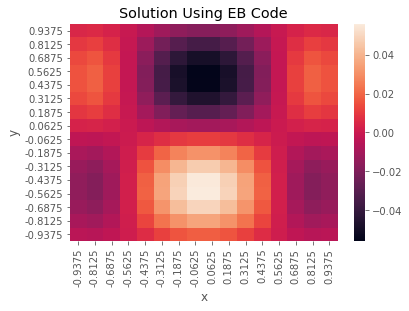

In [4]:
file = np.loadtxt("square_laplace.txt")
x = file[:, 0]
y = file[:, 1]
sol = file[:, 2]
plot_heatmap(x, y, sol, "Solution Using EB Code")

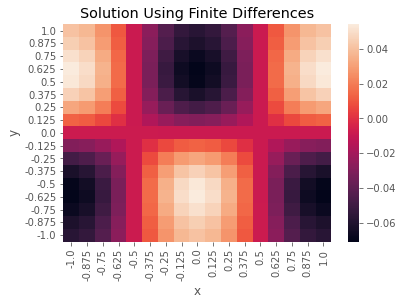

In [5]:
x, y, solution = laplacian_fd(.125)
plot_heatmap(x, y, solution, "Solution Using Finite Differences")

# Test Problem 2 
## a) Neumann Boundary Conditions Over a Circle

$$\nabla^2 \phi = x^2 + y^2 $$

with the Neumann boundary condition, $ \phi(x, y) = 1/4$ on the boundary $x^2 + y^2 = 1$.

The solution is

$$\phi(x, y) = \frac{1}{16}(x^2 + y^2)^2$$

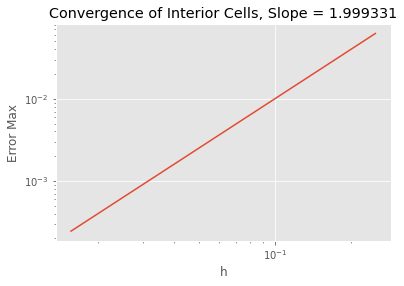

In [6]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle2/laplace-%d.txt" % i)
    # Interior Cells
    inside_cells = data.loc[data['Covered ID'] == 1]
    inside_x = inside_cells['CenterX']
    inside_y = inside_cells['CenterY']
    inside_laplace = inside_cells['Laplacian']
    inside_analytic = inside_x**2 + inside_y**2
    err = inside_cells['Volume Fraction']*inside_laplace - inside_cells['Volume Fraction']*inside_analytic
    norm.append(np.max(err))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Interior Cells, Slope = %f" % slope)
plt.show()

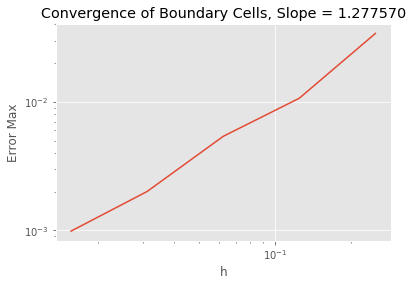

In [34]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle2/laplace-%d.txt" % i)
    # exterior Cells
    exterior_cells = data.loc[data['Covered ID'] == 2]
    exterior_x = exterior_cells['CenterX']
    exterior_y = exterior_cells['CenterY']
    exterior_laplace = exterior_cells['Laplacian']
    exterior_analytic = exterior_x**2 + exterior_y**2
    err = exterior_cells['Volume Fraction']*(exterior_laplace - exterior_analytic)
    norm.append(np.abs(np.max(err)))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Boundary Cells, Slope = %f" % slope)
plt.show()

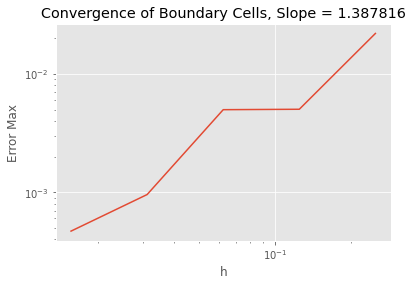

[0.02198042008499998,
 0.005024618693999953,
 0.004983197057999972,
 0.000955374376125053,
 0.000468748027906288]

In [19]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle_bd_moments/laplace-%d.txt" % i)
    exterior_cells = data.loc[data['Covered ID'] == 2]
    exterior_x = exterior_cells['CenterX']
    exterior_y = exterior_cells['CenterY']
    exterior_laplace = exterior_cells['Laplacian']
    exterior_analytic = exterior_x**2 + exterior_y**2
    err = exterior_cells['Volume Fraction']*(exterior_laplace - exterior_analytic)
    norm.append(np.abs(np.max(err)))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Boundary Cells, Slope = %f" % slope)
plt.show()
norm

### First Moment Convergence

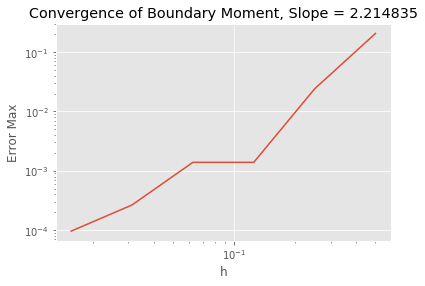

[0.20710536696942283,
 0.024094714839022924,
 0.0013884348920552014,
 0.0013884348920552014,
 0.00026500301882081967,
 9.605776999055404e-05]

In [69]:
norm = []
h = []
for i in range(1, 7):
    data = pd.read_csv("laplace_mesh_refine/circle_bd_moments/laplace-%d.txt" % i)
    boundary_cells = data.loc[data['Covered ID'] == 2]
    xy_eq = boundary_cells.loc[boundary_cells['CenterX'] == boundary_cells['CenterY']]
    xy_eq_pos = xy_eq.loc[xy_eq['CenterX'] > 0]
    analytic = np.sqrt(2)/2
    err = analytic - (xy_eq_pos['FirstX']/xy_eq_pos['Boundary Length'])
    norm.append(np.abs(np.max(err)))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Boundary Moment, Slope = %f" % slope)
plt.show()
norm

## b) Neuman Boundary Conditions over Circle of Radius $\sqrt{2}$

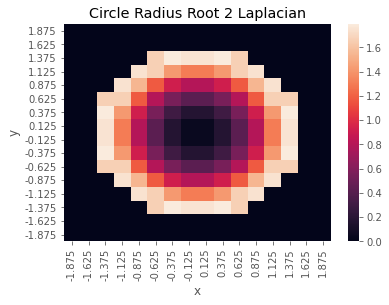

In [23]:
data = pd.read_csv("laplace_mesh_refine/circle_2rad2/laplace-4.txt")
x = data['CenterX']
y = data['CenterY']
plot_heatmap(x, y, data['Laplacian'], "Circle Radius Root 2 Laplacian")

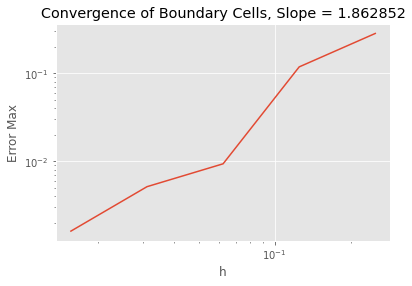

[0.281996,
 0.11767530618000006,
 0.009353293440000104,
 0.005145227062499902,
 0.0016111866093749458]

In [20]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle_2rad2/laplace-%d.txt" % i)
    exterior_cells = data.loc[data['Covered ID'] == 2]
    exterior_x = exterior_cells['CenterX']
    exterior_y = exterior_cells['CenterY']
    exterior_laplace = exterior_cells['Laplacian']
    exterior_analytic = exterior_x**2 + exterior_y**2
    err = exterior_cells['Volume Fraction']*(exterior_laplace - exterior_analytic)
    norm.append(np.abs(np.max(err)))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Boundary Cells, Slope = %f" % slope)
plt.show()
norm

## c) Neumann Boundary Conditions Over Circle Shifted 

### Volume Moments

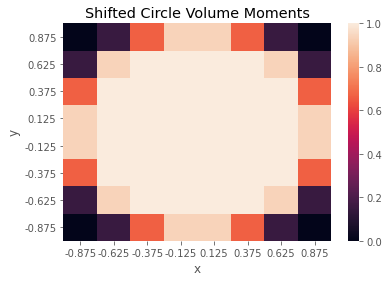

In [4]:
data = pd.read_csv("laplace_mesh_refine/circle_origin2/laplace-3.txt")
x = data['CenterX']
y = data['CenterY']
plot_heatmap(x, y, data['Volume Fraction'], "Shifted Circle Volume Moments")

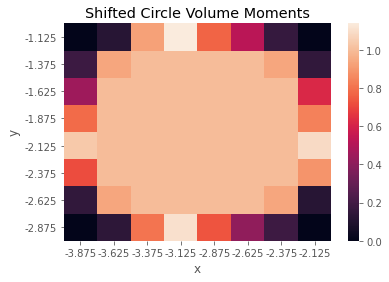

In [5]:
data = pd.read_csv("laplace_mesh_refine/circle_shifted2/laplace-3.txt")
x = data['CenterX']
y = data['CenterY']
plot_heatmap(x, y, data['Volume Fraction'], "Shifted Circle Volume Moments")

SHIFTED
LHS:   0 0.316228        0
       1 0.948683        0
       1        0 0.316228
       0        0 0.948683
RHO:-0.392949
    -1.25
    -0.218911
    -1.625
ZERO ZERO MOMENT: 0.283365
ZERO ONE BD MOMENT: -1.57894
ONE ZERO BD MOMENT: -1.70044

d_plus -1.375
d_minus -0.982051
s_sum 0
d_plus -1.25
d_minus 0
s_sum 0
d_plus -1.5
d_minus -1.28109
s_sum 0
d_plus -1.625
d_minus 0
s_sum 0

NOT SHIFTED
LHS:   0 0.316228        0
       1 0.948683        0
       1        0 0.316228
       0        0 0.948683
RHO:-0.125
    -0.25
    0.183013
    -0.125
ZERO ZERO MOMENT: 0.214711
ZERO ONE BD MOMENT: -0.480392
ONE ZERO BD MOMENT: -0.128609

d_plus -0.375
d_minus -0.25
s_sum 0
d_plus -0.25
d_minus 0
s_sum 0
d_plus 0
d_minus -0.183013
s_sum 0
d_plus -0.125
d_minus 0
s_sum 0

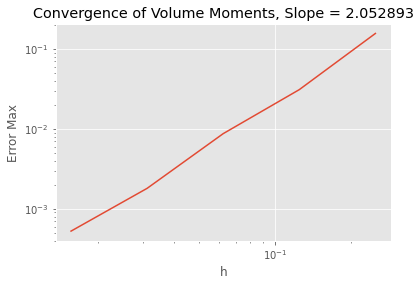

[0.15595215358979342,
 0.0309362160897928,
 0.00871205602729308,
 0.0018033143319806655,
 0.0005260929061994268]

In [25]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle_shifted2/laplace-%d.txt" % i)
    x = data['CenterX']
    y = data['CenterY']
    volume = data['Volume Fraction']*data['Cell Size']**2
    err = np.abs(np.pi - volume.sum())
    norm.append(err)
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Volume Moments, Slope = %f" % slope)
plt.show()
norm

### Laplacian

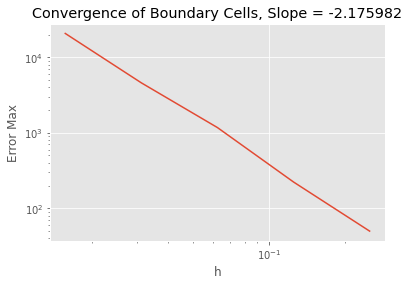

[49.716352917,
 222.58658112625,
 1172.1968759375,
 4588.601717660156,
 20732.044996629895]

In [30]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle_shifted2/laplace-%d.txt" % i)
    exterior_cells = data.loc[data['Covered ID'] == 2]
    exterior_x = exterior_cells['CenterX']
    exterior_y = exterior_cells['CenterY']
    exterior_laplace = exterior_cells['Laplacian']
    exterior_analytic = exterior_x**2 + exterior_y**2
    err = exterior_cells['Volume Fraction']*(exterior_laplace - exterior_analytic)
    norm.append(np.abs(np.max(err)))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Boundary Cells, Slope = %f" % slope)
plt.show()
norm

## d) Neumann Boundary Conditions Over an Ellipse

$$\nabla^2 \phi = x^2 + y^2 $$

with the Neumann boundary condition, $ \phi(x, y) = 1/4$ on the boundary $x^2 + 2y^2 = 1$.

The solution is

$$\phi(x, y) = \frac{1}{16}(x^2 + y^2)^2$$

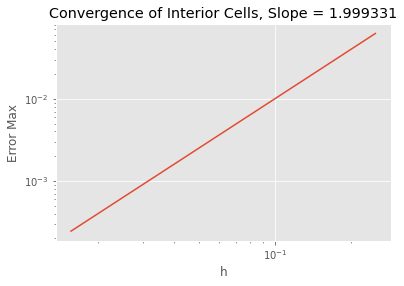

In [21]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/ellipse2/laplace-%d.txt" % i)
    # Interior Cells
    inside_cells = data.loc[data['Covered ID'] == 1]
    inside_x = inside_cells['CenterX']
    inside_y = inside_cells['CenterY']
    inside_laplace = inside_cells['Laplacian']
    inside_analytic = inside_x**2 + inside_y**2
    err = inside_cells['Volume Fraction']*inside_laplace - inside_cells['Volume Fraction']*inside_analytic
    norm.append(np.max(err))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Interior Cells, Slope = %f" % slope)
plt.show()

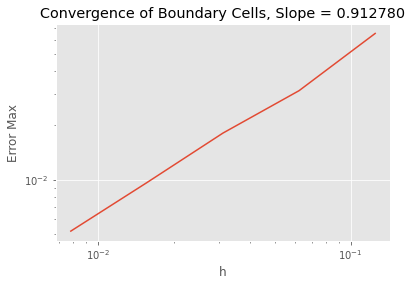

[0.064919768949,
 0.03120558212950003,
 0.018134308515375033,
 0.00961685812809374,
 0.005167494525950602]

In [34]:
norm = []
h = []
for i in range(3, 8):
    data = pd.read_csv("laplace_mesh_refine/ellipse2/laplace-%d.txt" % i)
    exterior_cells = data.loc[data['Covered ID'] == 2]
    exterior_x = exterior_cells['CenterX']
    exterior_y = exterior_cells['CenterY']
    exterior_laplace = exterior_cells['Laplacian']
    exterior_analytic = exterior_x**2 + exterior_y**2
    err = exterior_cells['Volume Fraction']*(exterior_laplace - exterior_analytic)
    norm.append(np.max(np.abs(err)))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Boundary Cells, Slope = %f" % slope)
plt.show()
norm

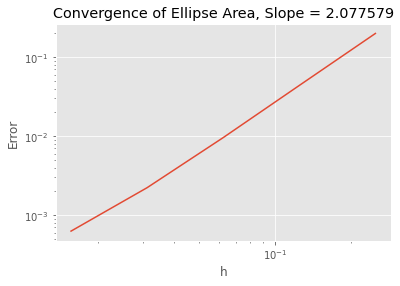

[0.1994360690791832,
 0.04384034407918325,
 0.009587600329183044,
 0.0022283097041828626,
 0.0006282744873864488]

In [20]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/ellipse2/laplace-%d.txt" % i)
    volume = (data['Volume Fraction']*data['Cell Size']**2).sum()
    err = (1/np.sqrt(2)*np.pi) - volume
    # Throw Out Cells Not In Domain
    norm.append(np.abs(err))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Ellipse Area, Slope = %f" % slope)
plt.show()
norm

## e) Ellipse Flipped 

$$\nabla^2 \phi = x^2 + y^2 $$

with the Neumann boundary condition, $ \phi(x, y) = 1/4$ on the boundary $2x^2 + y^2 = 1$.

The solution is

$$\phi(x, y) = \frac{1}{16}(x^2 + y^2)^2$$

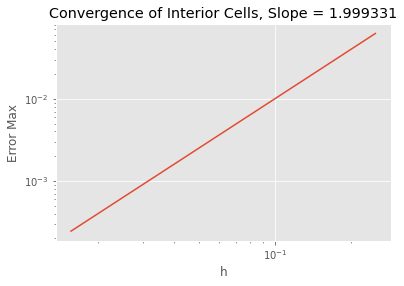

In [4]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/ellipseflip2/laplace-%d.txt" % i)
    # Interior Cells
    inside_cells = data.loc[data['Covered ID'] == 1]
    inside_x = inside_cells['CenterX']
    inside_y = inside_cells['CenterY']
    inside_laplace = inside_cells['Laplacian']
    inside_analytic = inside_x**2 + inside_y**2
    err = inside_cells['Volume Fraction']*inside_laplace - inside_cells['Volume Fraction']*inside_analytic
    norm.append(np.max(err))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Interior Cells, Slope = %f" % slope)
plt.show()

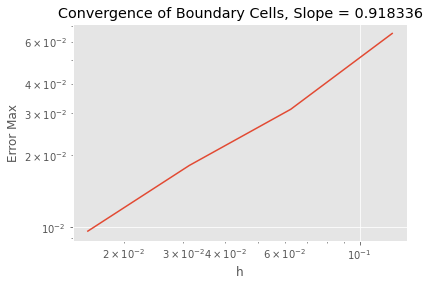

[0.064919450016,
 0.03120553527800003,
 0.018133787193625017,
 0.00961688553099999]

In [5]:
norm = []
h = []
for i in range(3, 7):
    data = pd.read_csv("laplace_mesh_refine/ellipseflip2/laplace-%d.txt" % i)
    exterior_cells = data.loc[data['Covered ID'] == 2]
    exterior_x = exterior_cells['CenterX']
    exterior_y = exterior_cells['CenterY']
    exterior_laplace = exterior_cells['Laplacian']
    exterior_analytic = exterior_x**2 + exterior_y**2
    err = exterior_cells['Volume Fraction']*(exterior_laplace - exterior_analytic)
    norm.append(np.max(np.abs(err)))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Boundary Cells, Slope = %f" % slope)
plt.show()
norm

# Test Problem 3
## Area of a circle 

For the circle $x^2 + y^2 = 1$, 

$err = |\pi - \text{sum of EB volumes} | $$

In [19]:
1/np.sqrt(2)

0.7071067811865475

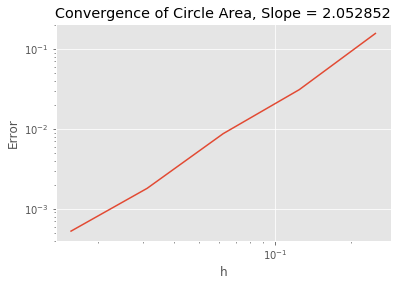

In [18]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle4/laplace-%d.txt" % i)
    volume = (data['Volume Fraction']*data['Cell Size']**2).sum()
    err = np.pi - volume
    # Throw Out Cells Not In Domain
    norm.append(np.abs(err))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Circle Area, Slope = %f" % slope)
plt.show()

A comparison of circumference

$$err = |2\pi - \textit{sum of EB boundary faces}|$$

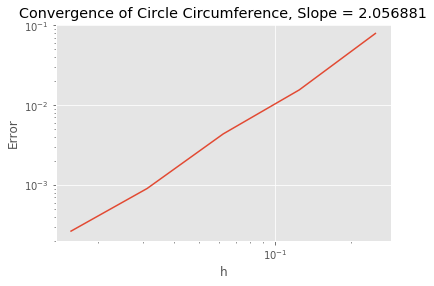

[0.0789693071795865,
 0.01550530717958587,
 0.004351707179586661,
 0.0009013071795864747,
 0.00026346717958602994]

In [2]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle2/laplace-%d.txt" % i)
    circumference = data['Boundary Length'].sum()
    err = 2*np.pi - circumference
    # Throw Out Cells Not In Domain
    norm.append(np.abs(err))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Circle Circumference, Slope = %f" % slope)
plt.show()
norm

# Test Problem 4
## Neumann Boundary Condition On a Circle

Consider the Laplacian over the unit circle

$$ \frac{\partial^2 u}{\partial r^2} + \frac{1}{r}\frac{\partial u}{\partial r}  + \frac{1}{r^2}\frac{\partial^2 u}{\partial \theta^2} = 0$$

with boundary conditions $u_r(1, \theta) = sin(\theta)$.

The solution is 

$$u(r, \theta) = r sin(\theta)$$

or in cartesian coordinates

$$u(x, y) = y$$

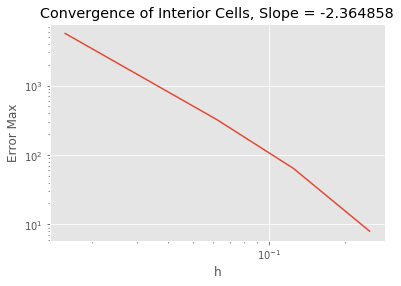

In [15]:
norm = []
h = []
for i in range(2, 7):
    data = pd.read_csv("laplace_mesh_refine/circle4/laplace-%d.txt" % i)
    # Interior Cells
    inside_cells = data.loc[data['Covered ID'] == 1]
    inside_x = inside_cells['CenterX']
    inside_y = inside_cells['CenterY']
    inside_laplace = inside_cells['Laplacian']
    inside_analytic = inside_y
    err = inside_laplace
    norm.append(np.max(err))
    h.append(1/2**i)
plt.loglog(h, norm)
plt.ylabel('Error Max')
plt.xlabel('h')
slope = (np.log(norm[-1])-np.log(norm[0]))/(np.log(h[-1])-np.log(h[0]))
plt.title("Convergence of Interior Cells, Slope = %f" % slope)
plt.show()

# Test Problem X
## Dirichlet Boundary Conditions Over a Circle

$$\nabla^2 \phi = x^2 + y^2 $$

with the Dirichlet boundary condition, $ \phi(x, y) = 0$ on the boundary $x^2 + y^2 = 1$.

The solution is

$$\phi(x, y) = \frac{1}{16}(x^2 + y^2)^2 - \frac{1}{16}$$